In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [18]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [21]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [31]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2] # , bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [32]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  # bnmeani = hpreact.mean(0, keepdim=True)
  # bnstdi = hpreact.std(0, keepdim=True)
  # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


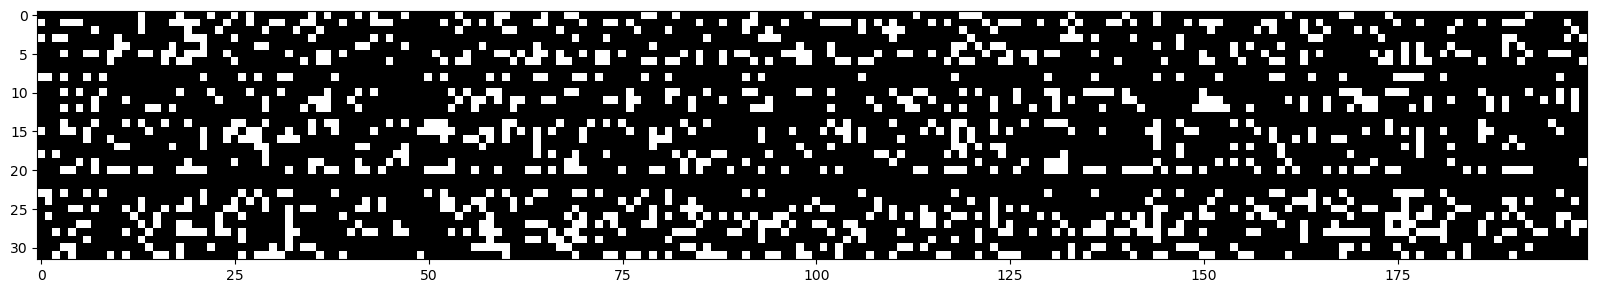

In [41]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([ 959.,  218.,  145.,  120.,  103.,  102.,   72.,   85.,   75.,
          70.,   69.,   74.,   69.,   68.,   76.,   65.,   49.,   77.,
          49.,  105.,   90.,   91.,  107.,   87.,   92.,  124.,  133.,
         101.,  101.,  120.,   71.,   86.,   60.,   73.,   44.,   73.,
          55.,   59.,   37.,   63.,   64.,   59.,   81.,   76.,   78.,
         133.,  130.,  143.,  261., 1058.]),
 array([-1.00000000e+00, -9.60000001e-01, -9.20000002e-01, -8.80000004e-01,
        -8.40000005e-01, -8.00000006e-01, -7.60000007e-01, -7.20000008e-01,
        -6.80000010e-01, -6.40000011e-01, -6.00000012e-01, -5.60000013e-01,
        -5.20000014e-01, -4.80000015e-01, -4.40000017e-01, -4.00000018e-01,
        -3.60000019e-01, -3.20000020e-01, -2.80000021e-01, -2.40000023e-01,
        -2.00000024e-01, -1.60000025e-01, -1.20000026e-01, -8.00000274e-02,
        -4.00000286e-02, -2.98023224e-08,  3.99999690e-02,  7.99999678e-02,
         1.19999967e-01,  1.59999965e-01,  1.99999964e-01,  2.399999

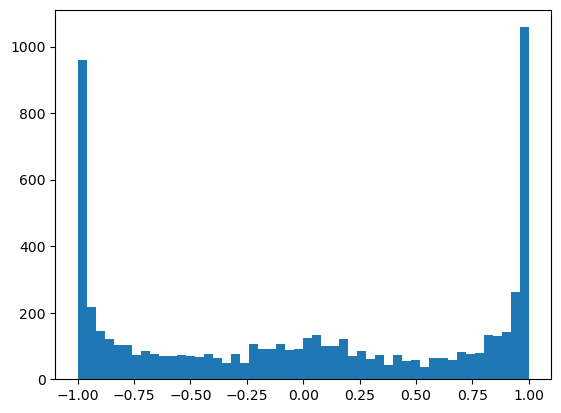

In [40]:
plt.hist(h.view(-1).tolist(), 50)

tensor(0.0042) tensor(1.0016)
tensor(0.0012) tensor(0.9973)


(array([3.82535299e-05, 3.82535299e-05, 3.82535299e-05, 1.53014120e-04,
        2.10394414e-04, 3.25155004e-04, 5.16422653e-04, 1.14760590e-03,
        2.06569061e-03, 3.06028239e-03, 6.35008596e-03, 1.02901995e-02,
        1.86103423e-02, 2.89961757e-02, 5.01121242e-02, 7.51490595e-02,
        1.15525660e-01, 1.70706377e-01, 2.34704533e-01, 3.08246944e-01,
        3.75401016e-01, 4.25570520e-01, 4.34081930e-01, 4.02886177e-01,
        3.35674725e-01, 2.65479497e-01, 1.91822326e-01, 1.34365524e-01,
        8.77344708e-02, 5.85661543e-02, 3.55566560e-02, 2.15941176e-02,
        1.29679466e-02, 7.19166362e-03, 4.07400093e-03, 2.92639504e-03,
        1.49188767e-03, 7.26817068e-04, 3.44281769e-04, 3.44281769e-04,
        1.33887355e-04, 5.73802948e-05, 3.82535299e-05, 1.91267649e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.91267649e-05]),
 array([-5.79936075, -5.53794697, -5.27653318, -5.0151194 , -4.75370562,
        -4.49229183, 

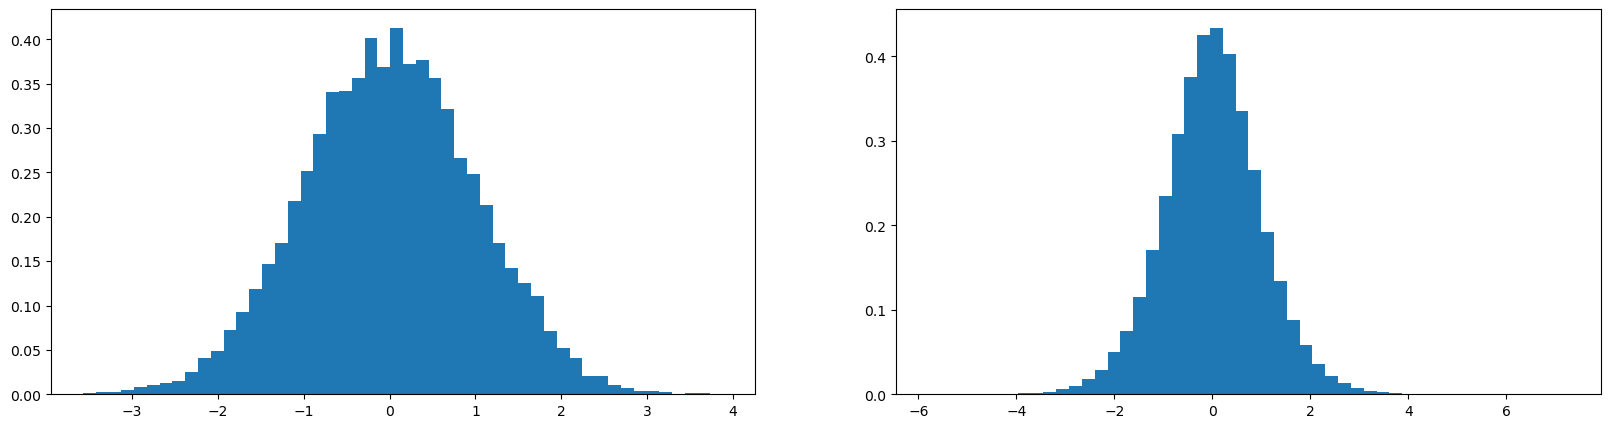

In [43]:
scaling_factor = 10 ** 0.5
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / scaling_factor
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

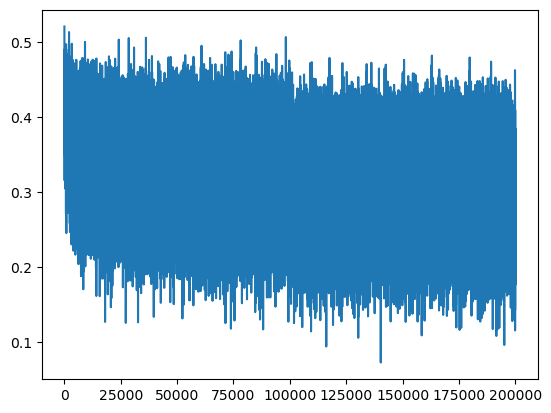

In [38]:
plt.plot(lossi)

In [39]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      h = torch.tanh(x @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
see.
mel.
ryllo.
emmrclendrami.
adered.
elin.
shyloe.
leigh.
estanar.
kayziquetra.
noshubergahimiest.
jairenellonnie.
casu.
zen.
dariyah.
faeh.
yuma.
myston.
